# Druglikeness

In the previous notebooks, we loaded a set of ligands of the serotonin 2c (5-HT2c) receptor, calculated some of their descriptors and compared those to all molecules in DrugBank.

Now we are going to look an the drug-likeness of these ligands based on several criteria, namely Lipinski's rule of five, Veber and Ghose rules.

Lipinski's rule of five:
 - no more than 5 hydrogen bond donors
 - no more than 10 hydrogen bond acceptors
 - molecular weight of less than 500 Da
 - logP less than 5

Ghose extension:
 - between 20 and 70 heavy atoms
 - molecular weight between 180 and 480
 - molar refractivity between 40 and 130 (measure of polarizability)
 - logp between -0.4 and 5.6 (measure of lipophilicity)
 
Veber's rule:
 - no more than 10 rotatable bonds
 - Molecular polar surface area up to 140 (correlates well with passive molecular transport through membranes *J. Med. Chem. 2000, 43, 20, 3714–3717*)
  

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import csv
import pandas as pd

with open('./data/DOWNLOAD-ligands_for_serotonine_rec.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    serotonine_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

## Functions for individual Lipinski's rules:

In [2]:
def too_many_hbd(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 5

def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 10

def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 500

def too_high_lipophilicity(mol):
    return Descriptors.MolLogP(mol) > 5

Some random structure from our set:

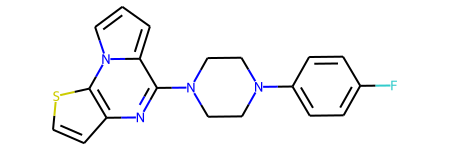

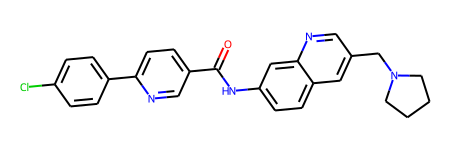

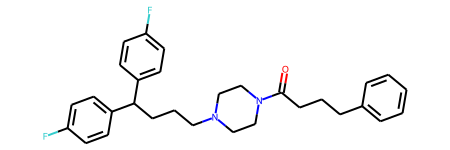

In [3]:
for idx in [1,54,876]:
    display(serotonine_ligands[idx])

## Filters applied to random molecule:

In [4]:
molecule = serotonine_ligands[54]
too_many_hbd(molecule), too_many_hba(molecule), too_heavy(molecule), too_high_lipophilicity(molecule)


(False, False, False, True)

One rule is violated, let's try another one:

In [5]:
molecule = serotonine_ligands[512]
too_many_hbd(molecule), too_many_hba(molecule), too_heavy(molecule), too_high_lipophilicity(molecule)


(False, False, False, False)

This one is ok :)

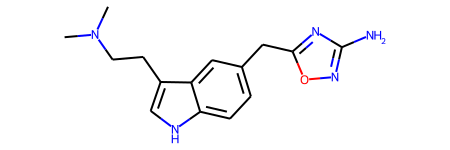

In [6]:
serotonine_ligands[512]

In [7]:
ligands_df = pd.DataFrame({"molecule": serotonine_ligands})
ligands_df["too_many_hbd"] = ligands_df["molecule"].apply(lambda l: too_many_hbd(l))
ligands_df["too_many_hba"] = ligands_df["molecule"].apply(lambda l: too_many_hba(l))
ligands_df["too_heavy"] = ligands_df["molecule"].apply(lambda l: too_heavy(l))
ligands_df["too_high_lipophilicity"] = ligands_df["molecule"].apply(lambda l: too_high_lipophilicity(l))

sum(ligands_df["too_many_hbd"]), sum(ligands_df["too_many_hba"]), \
sum(ligands_df["too_heavy"]), sum(ligands_df["too_high_lipophilicity"]), len(serotonine_ligands)
                                                         

(62, 88, 328, 327, 1876)

From these numbers, it seems that most of the ligands pass the RO5. If anything, weight and greasiness might be a problem, but only for about a sixth of the data.
These results seem slightly better than for mtor ligands.


In [8]:
ligands_df["set"] = "serotonine"


ligands_df.iloc[:,1:]

,too_many_hbd,too_many_hba,too_heavy,too_high_lipophilicity,set
0,False,False,True,False,serotonine
1,False,False,False,False,serotonine
2,False,False,False,False,serotonine
3,False,False,False,False,serotonine
4,False,False,False,False,serotonine
...,...,...,...,...,...
1871,False,False,False,False,serotonine
1872,False,False,False,False,serotonine
1873,False,False,False,False,serotonine
1874,False,False,False,True,serotonine


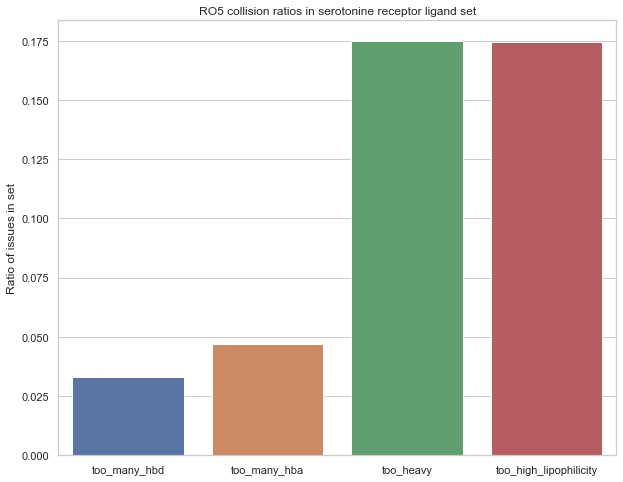

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)}) # for bigger graphs
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=ligands_df, ci=None)
    p.set_title("RO5 collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")

Here the biggest issue is that structures are too heavy and greasy. However, the common interpretation of LRO5 permits a single violation. It's hard to say whether this will help, since I'd expect to be heavy and greasy at the same time.

In [11]:
def ro5_violations(mol):
    # takes RDKit mol, return how many rules it actually violates
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_high_lipophilicity(mol)])

def violates_lipinski(mol):
    # checks the number of RO5 violations, if they are more than one, return True
    # Lipinski's rule allows one rule violation
    return ro5_violations(mol) > 1

In [12]:
ligands_df["ro5_violations"] = ligands_df["molecule"].apply(lambda l: ro5_violations(l))
ligands_df["violates_lipinski"] = ligands_df["molecule"].apply(lambda l: violates_lipinski(l))

In [13]:
sum(ligands_df["ro5_violations"]),\
sum(ligands_df["ro5_violations"])/len(ligands_df["ro5_violations"]),\
sum(ligands_df["violates_lipinski"]),\
sum(ligands_df["violates_lipinski"])/len(ligands_df["violates_lipinski"])

(805, 0.4291044776119403, 247, 0.13166311300639658)

The overall number of RO5 violations in the serotonine receptor ligand set is 805, which makes a bit less than a half violation per molecule. 247 ligands, about 13% of the dataset, violate more than one LRO5 rule, and thus fail the standard Lipinski filter.

In [14]:
df = ligands_df[["set", "too_many_hbd","too_many_hba", "too_heavy", "too_high_lipophilicity", "violates_lipinski"]]
df.head()

,set,too_many_hbd,too_many_hba,too_heavy,too_high_lipophilicity,violates_lipinski
0,serotonine,False,False,True,False,False
1,serotonine,False,False,False,False,False
2,serotonine,False,False,False,False,False
3,serotonine,False,False,False,False,False
4,serotonine,False,False,False,False,False


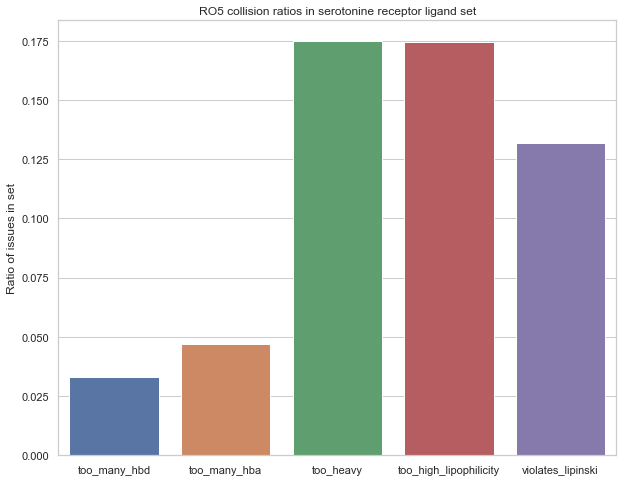

In [15]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df, ci=None)
    p.set_title("RO5 collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")

Let's do the Ghose extension that remaps the requirements for logP and molecular weight, and instead of HBA and HBD uses molar refractivity and number of atoms. Also the Veber's rule on rotatable bonds and polar surface area:

In [16]:
from rdkit.Chem import Crippen

def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

# let's apply the filters and add them to the dataframe as we go
ligands_df['odd_greasyness'] = ligands_df["molecule"].apply(lambda l: bad_greasyness_ghose(l))

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
ligands_df['odd_refractivity'] = ligands_df["molecule"].apply(lambda l: bad_refractivity_ghose(l))

def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
ligands_df['odd_mass'] = ligands_df["molecule"].apply(lambda l: bad_mw_ghose(l))

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
ligands_df['odd_atomcount'] = ligands_df["molecule"].apply(lambda l: bad_atomcount_ghose(l))

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
ligands_df['fails_ghose'] = ligands_df["molecule"].apply(lambda l: violates_ghose(l))

def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
ligands_df['too_rotatable'] = ligands_df["molecule"].apply(lambda l: too_rotatable_veber(l))

def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
ligands_df['excessive_psa'] = ligands_df["molecule"].apply(lambda l: too_large_psa_veber(l))

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
ligands_df['fails_veber'] = ligands_df["molecule"].apply(lambda l: violates_veber(l))

## Visualization of ALL rules

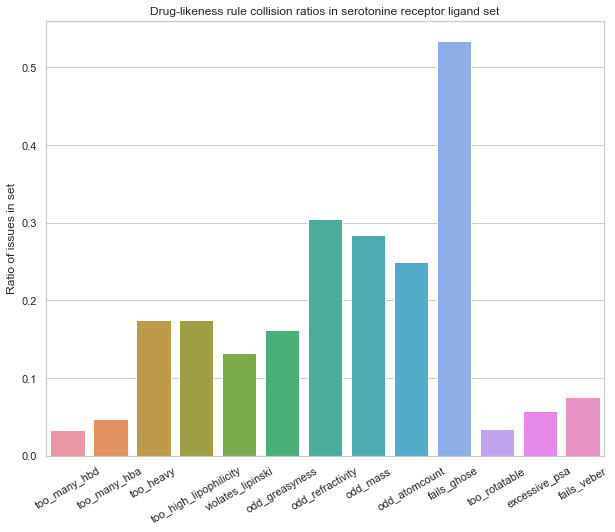

In [17]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=ligands_df.drop(["molecule", "ro5_violations"], axis=1), ci=None)
    p.set_title("Drug-likeness rule collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

More than half of serotonine receptor ligands violae Ghose filter, since it doesn't allow even one violation, unlike Lipinski. The most violated of the Ghose rules is refractivity, same as for MTOR ligands, some molecules also have a too high mass.

Similar to MTOR ligands, only very few ligands violate the Veber rules, almost none have too many rotatable bonds and next to none have too much polar surface area, so passing through membranes should not be an issue.

However, when we consider the Ghose rules, more than half of the dataset is disqualified.

To gain some perspective, let's do the same measurements for all the drugs in DrugBank.



In [18]:
df_drugbank = pd.DataFrame(
    data={'set':'DrugBank',
          "molecule": drugs})
df_drugbank["too_many_hbd"] = df_drugbank["molecule"].apply(lambda l: too_many_hbd(l))
df_drugbank["too_many_hba"] = df_drugbank["molecule"].apply(lambda l: too_many_hba(l))
df_drugbank["too_high_lipophilicity"] = df_drugbank["molecule"].apply(lambda l: too_high_lipophilicity(l))
df_drugbank["too_heavy"] = df_drugbank["molecule"].apply(lambda l: too_heavy(l))
df_drugbank["fails_lipinski"] = df_drugbank["molecule"].apply(lambda l: violates_lipinski(l))
df_drugbank["odd_greasyness"] = df_drugbank["molecule"].apply(lambda l: bad_greasyness_ghose(l))
df_drugbank["odd_refractivity"] = df_drugbank["molecule"].apply(lambda l: bad_refractivity_ghose(l))
df_drugbank["odd_mass"] = df_drugbank["molecule"].apply(lambda l: bad_mw_ghose(l))
df_drugbank["odd_atomcount"] = df_drugbank["molecule"].apply(lambda l: bad_atomcount_ghose(l))
df_drugbank["fails_ghose"] = df_drugbank["molecule"].apply(lambda l: violates_ghose(l))
df_drugbank["too_rotatable"] = df_drugbank["molecule"].apply(lambda l: too_rotatable_veber(l))
df_drugbank["excessive_psa"] = df_drugbank["molecule"].apply(lambda l: too_large_psa_veber(l))
df_drugbank["fails_veber"] = df_drugbank["molecule"].apply(lambda l: too_large_psa_veber(l))
df_drugbank.head()

,set,molecule,too_many_hbd,too_many_hba,too_high_lipophilicity,too_heavy,fails_lipinski,odd_greasyness,odd_refractivity,odd_mass,odd_atomcount,fails_ghose,too_rotatable,excessive_psa,fails_veber
0,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,True,True,False,True,True,True,True,True,True,True,True,True,True
1,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,True,True,False,True,True,True,True,True,True,True,True,True,True
2,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,True,True,False,True,True,True,True,True,True,True,True,True,True
3,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,True,True,False,True,True,True,True,True,True,True,True,True,True
4,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,True,False,True,True,False,True,True,True,True,True,True,True


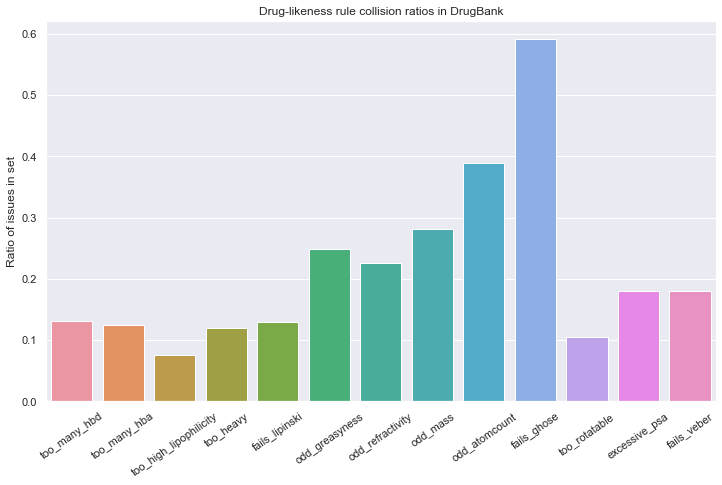

In [19]:
with sns.axes_style("whitegrid"):
    sns.set(rc={'figure.figsize':(12,7)})
    p = sns.barplot(data=df_drugbank.iloc[1:], ci=None)
    p.set_title("Drug-likeness rule collision ratios in DrugBank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=35)

DrugBank molecules have a similar fraction that fails Lipinski, although fewer drugs fail the individual rules. As for Ghose, even more drugs than in the serotonine receptor set violate the rules, especially atom count, with almost 40% of drugs being out of bounds. Quite a few (about 28%) also have to high a molecular weight, refractivity is not that much of an issue.

In DrugBank, a much higher proportion of molecules violates the Veber rules, more than 10% have too many rotatable bonds and almost 20% have excessive polar surface (for the serotonine receptor set, this was only around 4% and 6%, respectively).

For both datasets, Ghose rules seem to be the most problematic.

This demonstrates that the Lipinski and indeed all other similar filters should be used as they are intended: as rough outlines of druglike properties, not as an evangelium. They can help you identify the truly hopeless structures, but there is no need to thrash an otherwise promising molecule just because it violates one or two rules.

# What to do
 - Have a look at Lipinski and other filters, linked in the workflow
 - Implement the rules, either as done here, or by other methods of your preference. Please try not to just copypaste the solution, and make sure that you understand what is being done. I can't freeze frame the classroom projector here, so honor system only :)
 - Run the filters on your set, evaluate the results, compare with MTOR results, and with DrugBank
 - How many ligands in your set fail the filters, what is their ratio?
 - What rules are the most frequently failed ones? 
 - How does the absolute numbers, as well as failure rate of individual rules compare to MTOR ligands and DrugBank?
 - Finally, to not just copypaste code, also look at lead-likeness filter, which is even more stringent than drug-likeness one (LogP 3 or less, molecular weight below 300 Da, max 3 HBA, max 3 HBD, and no more than 3 rotatable bonds). It is more strict so that there is some extra space for pharmaceutical lead to be further developed for specificity and/or potency by adding additional groups without the molecule getting too large and greasy. Implement this filter much like the Lipinski or Ghose one, and perform the corresponding visualizations. How many of your known ligands have lead-like properties that would make them good candidates for further drug development? How do the already developed drugs in DrugBank fare against your filter?

## Lead-likeness

 - logp 3 or less
 - MW below 300 Da
 - up to 3 hydrogen bond acceptors
 - up to 3 hydrogen bond donors
 - no more than 3 rotatable bonds

In [20]:
# lead-likeness filters

def lead_logp_violation(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 3

def lead_too_heavy(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 300

def lead_too_many_hbd(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 3

def lead_too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 3

def lead_too_many_rotatable(mol):
    rot_bonds = Chem.CalcNumRotatableBonds(mol)
    return rot_bonds > 3

In [21]:
ligands_df["lead_hbd"] = ligands_df["molecule"].apply(lambda l: lead_too_many_hbd(l))
ligands_df["lead_hba"] = ligands_df["molecule"].apply(lambda l: lead_too_many_hba(l))
ligands_df["lead_too_heavy"] = ligands_df["molecule"].apply(lambda l: lead_too_heavy(l))
ligands_df["lead_high_lipophilicity"] = ligands_df["molecule"].apply(lambda l: lead_logp_violation(l))
ligands_df["lead_too_rotatable"] = ligands_df["molecule"].apply(lambda l: lead_too_many_rotatable(l))

sum(ligands_df["lead_hbd"]), sum(ligands_df["lead_hba"]), \
sum(ligands_df["lead_too_heavy"]), sum(ligands_df["lead_high_lipophilicity"]), \
sum(ligands_df["lead_too_rotatable"]), len(serotonine_ligands)

(176, 1474, 1291, 1072, 1185, 1876)

In [22]:
def all_false(line):
    return not any(list(line))

ligands_df["pass_lead_likeness"] = ligands_df[["lead_hbd", "lead_hba", "lead_too_heavy", "lead_high_lipophilicity", \
                                               "lead_too_rotatable"]].apply(all_false, axis=1)

In [23]:
ligands_df.head()

,molecule,too_many_hbd,too_many_hba,too_heavy,too_high_lipophilicity,set,ro5_violations,violates_lipinski,odd_greasyness,odd_refractivity,...,fails_ghose,too_rotatable,excessive_psa,fails_veber,lead_hbd,lead_hba,lead_too_heavy,lead_high_lipophilicity,lead_too_rotatable,pass_lead_likeness
0,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,True,False,serotonine,1,False,False,True,...,True,False,False,False,False,True,True,True,True,False
1,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,True,True,True,False,False
2,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,True,True,False,False,False
3,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,True,True,False,True,False


In [24]:
total = len(serotonine_ligands)
print(f"Total molecules: {len(serotonine_ligands)}")
print(f'{sum(ligands_df["pass_lead_likeness"])} molecules pass filters for pharmaceutical lead. ({sum(100 * ligands_df["pass_lead_likeness"]) / total:.2f}%)')
print()
print("Violations:")

print(f'{sum(ligands_df["lead_hbd"])} molecules have too many hydrogen bond donors. ({sum(100 * ligands_df["lead_hbd"]) / total:.2f}%)')
print(f'{sum(ligands_df["lead_hba"])} molecules have too many hydrogen bond acceptors. ({sum(100 * ligands_df["lead_hba"]) / total:.2f}%)')
print(f'{sum(ligands_df["lead_too_heavy"])} molecules are too heavy. ({sum(100 * ligands_df["lead_too_heavy"]) / total:.2f}%)')
print(f'{sum(ligands_df["lead_high_lipophilicity"])} molecules are too greasy (high LogP). ({sum(100 * ligands_df["lead_high_lipophilicity"]) / total:.2f}%)')
print(f'{sum(ligands_df["lead_too_rotatable"])} molecules have too many rotatable bonds. ({sum(100 * ligands_df["lead_too_rotatable"]) / total:.2f}%)')

Total molecules: 1876
147 molecules pass filters for pharmaceutical lead. (7.84%)

Violations:
176 molecules have too many hydrogen bond donors. (9.38%)
1474 molecules have too many hydrogen bond acceptors. (78.57%)
1291 molecules are too heavy. (68.82%)
1072 molecules are too greasy (high LogP). (57.14%)
1185 molecules have too many rotatable bonds. (63.17%)


## Visualization of lead filters

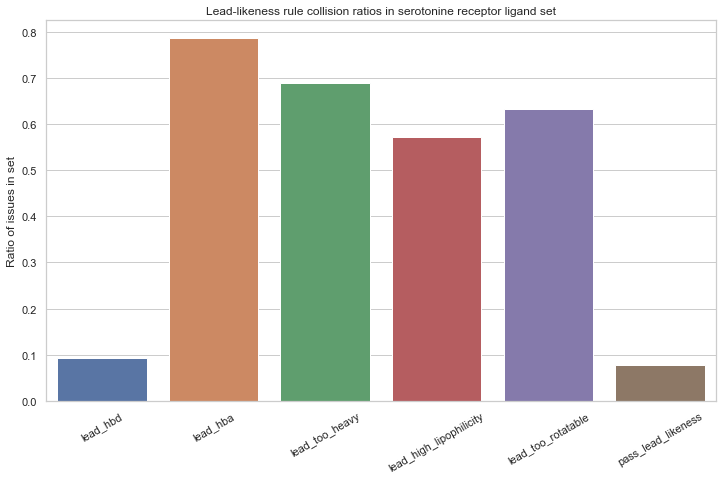

In [25]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=ligands_df[["lead_hbd", "lead_hba", "lead_too_heavy", "lead_high_lipophilicity", \
                                               "lead_too_rotatable", "pass_lead_likeness"]], ci=None)
    p.set_title("Lead-likeness rule collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

We see that not many of these ligands would pass the filter to be used as leads for drug discovery. Hydrogen bond donors are not a problem, but almost all of the other rules filter out a significant part of the set, with only less than 8% left.

Most molecules fail the filters besause of too many hydrogen bond acceptors. Let's see if this can be explained by the contents of heteroatoms (hydrogen bonds are usually formed with electornegative atoms like O, N).

Other than that, the molecules are often too heavy or too greasy, which is not that surprising given that most contain multiple aromatic rings etc.

In [26]:
from statistics import mean

serotonine_heteroatoms_ratio = [rdescriptors.CalcNumHeteroatoms(l)/l.GetNumHeavyAtoms() 
                                for l in serotonine_ligands if l.GetNumHeavyAtoms()]
drugbank_heteroatoms_ratio = [rdescriptors.CalcNumHeteroatoms(l)/l.GetNumHeavyAtoms() 
                              for l in drugs if l.GetNumHeavyAtoms()]
mean_hetatm_ratio_serotonine = mean(serotonine_heteroatoms_ratio)
mean_hetatm_ratio_drugbank = mean(drugbank_heteroatoms_ratio)

print(mean_hetatm_ratio_serotonine)
print(mean_hetatm_ratio_drugbank)

0.2580565113200825
0.33024628693757674


In [27]:
df = pd.DataFrame(data=[{'set': 'serotonine', 'heteroatom_ratio': x}
                        for x in serotonine_heteroatoms_ratio])
df = df.append(pd.DataFrame(data=[{'set': 'drugbank', 'heteroatom_ratio': x}
                                  for x in drugbank_heteroatoms_ratio]), ignore_index=True)
df.head()

,set,heteroatom_ratio
0,serotonine,0.179487
1,serotonine,0.240000
2,serotonine,0.285714
3,serotonine,0.166667
4,serotonine,0.428571


Text(0.5, 1.0, 'Hetero atom ratio')

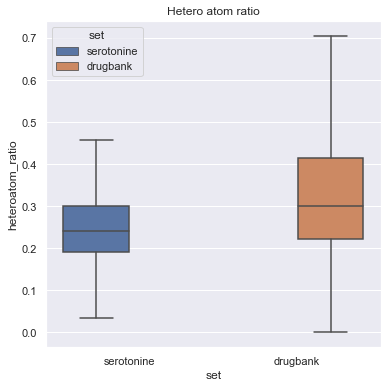

In [33]:
sns.set(rc={'figure.figsize':(6,6)})
p = sns.boxplot(x='set', y='heteroatom_ratio', hue='set', data=df, showfliers=False)
p.set_title("Hetero atom ratio")

It looks like the ratio of heteroatoms is actually slightly lower than in all of drugbank. So let's see, how well DrugBank stands with the lead-likeness filters.

In [29]:
df_drugbank["lead_hbd"] = df_drugbank["molecule"].apply(lambda l: lead_too_many_hbd(l))
df_drugbank["lead_hba"] = df_drugbank["molecule"].apply(lambda l: lead_too_many_hba(l))
df_drugbank["lead_too_heavy"] = df_drugbank["molecule"].apply(lambda l: lead_too_heavy(l))
df_drugbank["lead_high_lipophilicity"] = df_drugbank["molecule"].apply(lambda l: lead_logp_violation(l))
df_drugbank["lead_too_rotatable"] = df_drugbank["molecule"].apply(lambda l: lead_too_many_rotatable(l))

sum(df_drugbank["lead_hbd"]), sum(df_drugbank["lead_hba"]), \
sum(df_drugbank["lead_too_heavy"]), sum(df_drugbank["lead_high_lipophilicity"]), \
sum(df_drugbank["lead_too_rotatable"]), len(drugs)

df_drugbank["pass_lead_likeness"] = df_drugbank[["lead_hbd", "lead_hba", "lead_too_heavy", "lead_high_lipophilicity", \
                                               "lead_too_rotatable"]].apply(all_false, axis=1)

In [30]:
total = len(drugs)
print(f"Total molecules: {len(drugs)}")
print(f'{sum(df_drugbank["pass_lead_likeness"])} molecules pass filters for pharmaceutical lead. ({sum(100 * df_drugbank["pass_lead_likeness"]) / total:.2f}%)')
print()
print("Violations:")

print(f'{sum(df_drugbank["lead_hbd"])} molecules have too many hydrogen bond donors. ({sum(100 * df_drugbank["lead_hbd"]) / total:.2f}%)')
print(f'{sum(df_drugbank["lead_hba"])} molecules have too many hydrogen bond acceptors. ({sum(100 * df_drugbank["lead_hba"]) / total:.2f}%)')
print(f'{sum(df_drugbank["lead_too_heavy"])} molecules are too heavy. ({sum(100 * df_drugbank["lead_too_heavy"]) / total:.2f}%)')
print(f'{sum(df_drugbank["lead_high_lipophilicity"])} molecules are too greasy (high LogP). ({sum(100 * df_drugbank["lead_high_lipophilicity"]) / total:.2f}%)')
print(f'{sum(df_drugbank["lead_too_rotatable"])} molecules have too many rotatable bonds. ({sum(100 * df_drugbank["lead_too_rotatable"]) / total:.2f}%)')

Total molecules: 7115
702 molecules pass filters for pharmaceutical lead. (9.87%)

Violations:
2286 molecules have too many hydrogen bond donors. (32.13%)
5481 molecules have too many hydrogen bond acceptors. (77.03%)
4107 molecules are too heavy. (57.72%)
2385 molecules are too greasy (high LogP). (33.52%)
4362 molecules have too many rotatable bonds. (61.31%)


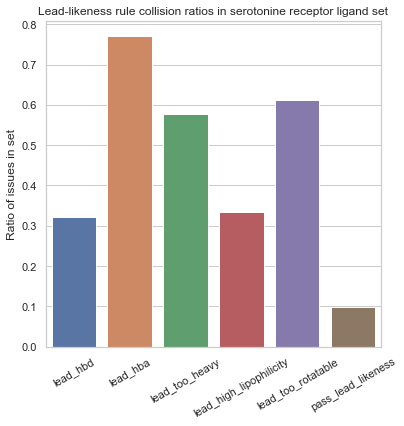

In [31]:
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_drugbank[["lead_hbd", "lead_hba", "lead_too_heavy", "lead_high_lipophilicity", \
                                               "lead_too_rotatable", "pass_lead_likeness"]], ci=None)
    p.set_title("Lead-likeness rule collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

Unsurprisingly, a similar number of molecules in DrugBank violates the hydrogen bond acceptor rule and even more than in the previous set have too many hydrogen bond donors. A similar ~10% of all molecules passes all of the filters.

## Grand finale
Now for the final visualization of *all* the filters.

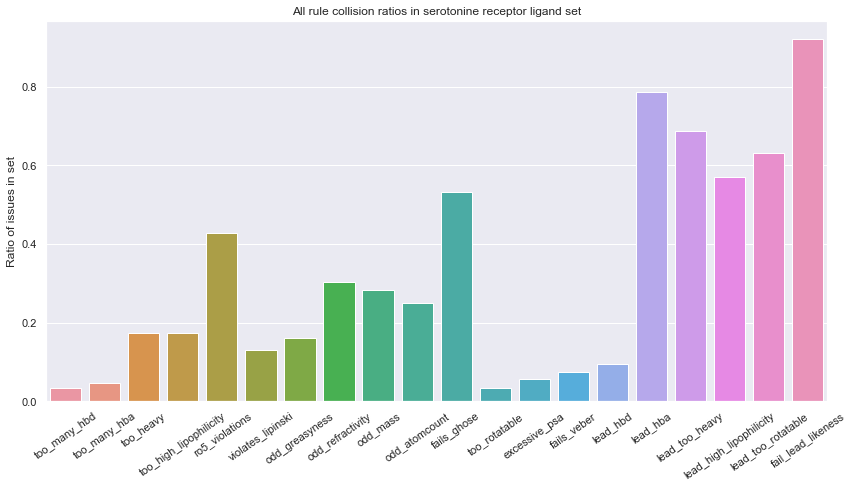

In [32]:
ligands_df["fail_lead_likeness"] = ~ligands_df["pass_lead_likeness"]
with sns.axes_style("whitegrid"):
    sns.set(rc={'figure.figsize':(14,7)})
    p = sns.barplot(data=ligands_df.drop(["pass_lead_likeness"], axis=1).iloc[1:], ci=None)
    p.set_title("All rule collision ratios in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=35) 

## Only complex rules

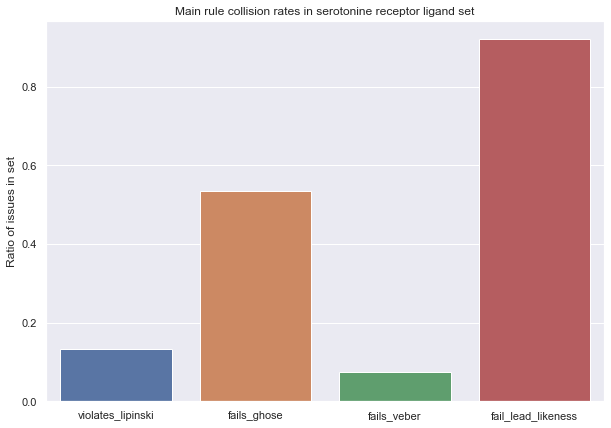

In [54]:
with sns.axes_style("whitegrid"):
    sns.set(rc={'figure.figsize':(10,7)})
    p = sns.barplot(data=ligands_df[["violates_lipinski", "fails_ghose", "fails_veber", "fail_lead_likeness"]], ci=None)
    p.set_title("Main rule collision rates in serotonine receptor ligand set")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels()) 

In [46]:
total = len(serotonine_ligands)
print(f"Total molecules: {len(serotonine_ligands)}")
print(f'{total - sum(ligands_df["violates_lipinski"])} molecules pass Lipinski\'s rule of 5. ({100 - sum(100 * ligands_df["violates_lipinski"]) / total:.2f}%)')
print(f'{total - sum(ligands_df["fails_ghose"])} molecules pass Ghose filter. ({100 - sum(100 * ligands_df["fails_ghose"]) / total:.2f}%)')
print(f'{total - sum(ligands_df["fails_veber"])} molecules pass Veber filter. ({100 - sum(100 * ligands_df["fails_veber"]) / total:.2f}%)')
print(f'{sum(ligands_df["pass_lead_likeness"])} molecules pass filters for pharmaceutical lead. ({sum(100 * ligands_df["pass_lead_likeness"]) / total:.2f}%)')


Total molecules: 1876
1629 molecules pass Lipinski's rule of 5. (86.83%)
875 molecules pass Ghose filter. (46.64%)
1735 molecules pass Veber filter. (92.48%)
147 molecules pass filters for pharmaceutical lead. (7.84%)


In [49]:
leads = ligands_df[ligands_df["pass_lead_likeness"] == True]
leads.head()

,molecule,too_many_hbd,too_many_hba,too_heavy,too_high_lipophilicity,set,ro5_violations,violates_lipinski,odd_greasyness,odd_refractivity,...,too_rotatable,excessive_psa,fails_veber,lead_hbd,lead_hba,lead_too_heavy,lead_high_lipophilicity,lead_too_rotatable,pass_lead_likeness,fail_lead_likeness
3,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
24,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,True,...,False,False,False,False,False,False,False,False,True,False
34,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
60,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
87,<rdkit.Chem.rdchem.Mol object at 0x000001505AD...,False,False,False,False,serotonine,0,False,False,True,...,False,False,False,False,False,False,False,False,True,False


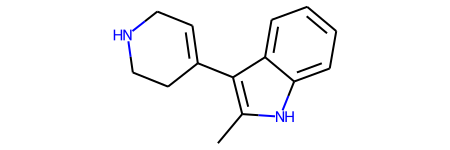

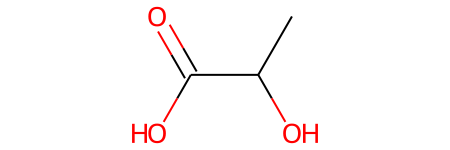

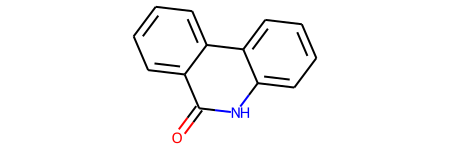

In [52]:
for i in [3, 13, 120]:
    display(leads.iloc[i]["molecule"])